# Анализ клиентов фитнес-центра «Культурист-датасаентист»

## Описание проекта
  Одна из самых распространенных проблем фитнес-центров — отток клиентов. Сложно сходу понять, какие были предпосылки для этого, факторов может быть много, а может быть один, например, если клиент перестал ходить в зал в последний месяц, но и это может бытьошибочным. Для правильного взаимодействия с клиентами необходимо провести анализ клиентских анкет и подготовить план по удержанию.
- Спрогнозировать отток клиентов в следующем месяце.
- Распределить клиентов по наиболее ярко выраженным группам.
- Проанализировать признаки, влияющие на отток.
- Предложить меры по снижению оттока клиентов.

# Обзор данных

In [1]:
#загружаем библиотки
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.cluster import KMeans
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from scipy.cluster.hierarchy import dendrogram, linkage

#устанавливаем белый фон и шрифт покрупнее для графиков
sns.set_theme(style="white", font_scale=1.5)

In [2]:
#загружаем данные
try:
    data = pd.read_csv('/datasets/gym_churn.csv')
except:
    data = pd.read_csv('datasets/gym_churn.csv')

#знакомимся с данными
data.info()
display(data.head());

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


Данные выглядят хорошо, нет пропусков, типы соответствуют. У нас имеется 14 признаков и 4000 записей.

# Исследовательский анализ данных (EDA)

In [3]:
data.columns = data.columns.str.lower()
data.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
near_location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000


'gender' — пол, примерно поровну.

'near_Location' — Больше местных, отклонение не сильное.

'partner' — сотрудников компании-партнёра клуба примерно половина.

'promo_friends' — около трети клиентов пришли по приглашению друзей.

'phone' — контактный телефон оставили около 90% клиентов.

'contract_period' — в среднем, кленты берут абонемент на 5 месяцев, но половина только на один.

'group_visits' — почти половина посещает групповые занятия.

'age' — средний возраст 29 лет, плюс-минус 3 года.

'avg_additional_charges_total' — средняя выручка от других услуг с большим разбросом.

'month_to_end_contract' — в среднем в таблице клиенты, которым осталось 4 месяца до конца действия абонемента, но половине из них остался месяц.

'lifetime' — в таблице 75% клиентов, обратившиеся в центр меньше 5 месяцев назад.

'avg_class_frequency_total' — в среднем, клиенты ходят в зал 2 раза в неделю.

'avg_class_frequency_current_month' — а за последний месяц количество посещений в неделю не сильно меняется.

'churn' — в среднем, клиенты в три раза чаще остаются с клубом, чем уходят.

### Разделим клиентов на две группы по факту ухода.

In [4]:
data.groupby('churn').mean().reset_index().T

,0,1
churn,0.000000,1.000000
gender,0.510037,0.510839
near_location,0.873086,0.768143
partner,0.534195,0.355325
promo_friends,0.353522,0.183789
phone,0.903709,0.902922
contract_period,5.747193,1.728558
group_visits,0.464103,0.268615
age,29.976523,26.989632
avg_additional_charges_total,158.445715,115.082899


Средние значения по группам:

'gender' — пол, примерно поровну.

'near_Location' — местные чуть реже уходят.

'partner' — клиенты по партнерской программе уходят реже.

'promo_friends' — пришедшие по приглашению чаще остаются.

'phone' — у обоих групп контактный номер оставлен 90% клиентов.

'contract_period' — те, кто остался, имеют абонемент на полгода, а кто ушел - на месяц.

'group_visits' — ушедшие клиенты вдвое реже ходят на групповые занятия.

'age' — средний возраст примерно одинаковый, 27-30 лет.

'avg_additional_charges_total' — средняя выручка от других услуг выше у оставшихся.

'month_to_end_contract' — логично, что у оставшийся клиентов около 5 месяцев осталось по абонементу, а у ушедших около месяца.

'lifetime' — также и с временем обращения в центр.

'avg_class_frequency_total' — примечательно, что чаще в зал ходят те, кто в последствие бросает занятия.

'avg_class_frequency_current_month' — и в последний месяц количество посещений не меняется, а у оставшихся снижается до одного раза в неделю.

### Посмотрим на распределение признаков по группам

In [5]:
#разделим таблицу на категориальные и количественные признаки
categorical_names = data.columns[data.max() == 1].tolist()
quantitative_names = data.columns[data.max() > 1].tolist()

categorical = data[categorical_names]
quantitative = data[quantitative_names]
quantitative = quantitative.assign(churn=data['churn'])

#проверим, что все правильно разделилось
display(categorical.head(2))
display(quantitative.head(2))

,gender,near_location,partner,promo_friends,phone,group_visits,churn
0,1,1,1,1,0,1,0
1,0,1,0,0,1,1,0


,contract_period,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,6,29,14.227470,5.0,3,0.020398,0.000000,0
1,12,31,113.202938,12.0,7,1.922936,1.910244,0


Построим графики.

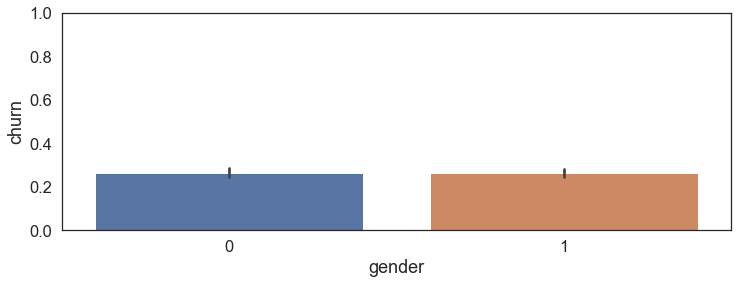

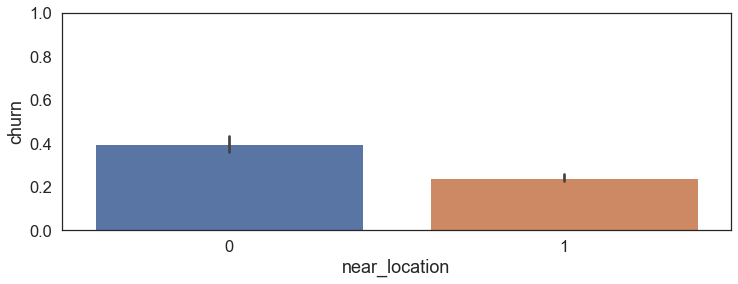

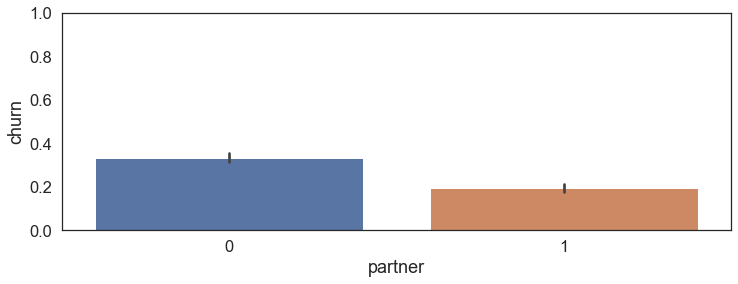

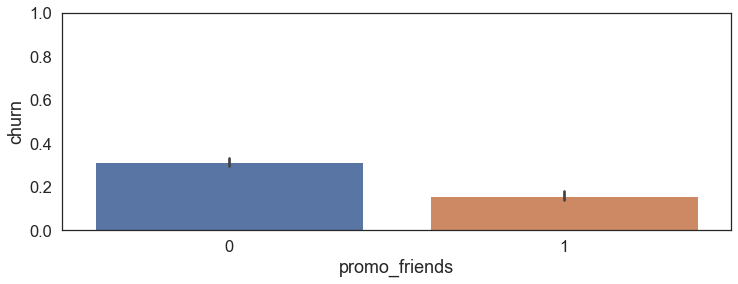

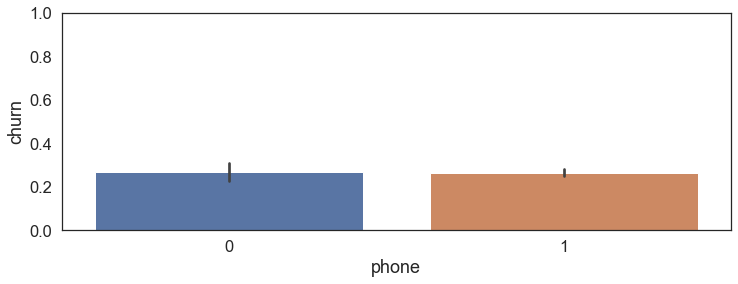

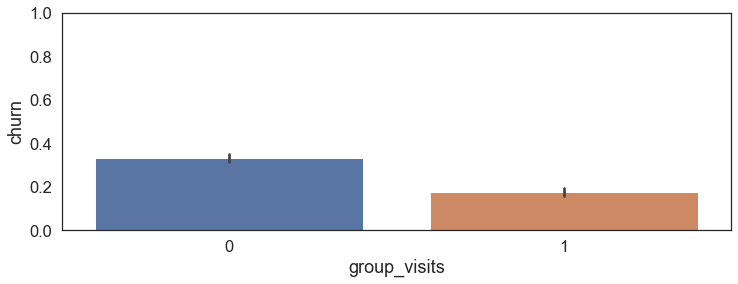

In [6]:
for col in categorical.drop('churn', axis = 1).columns:
    fig, ax = plt.subplots(figsize=(12, 4))
    sns.barplot(x=categorical[col], y=categorical['churn'])
    plt.ylim(0, 1)
    plt.show();

Судя по графикам категориальных переменных, чаще уходят клиенты, которые не живут рядом, пришли по приглашению или по портнёрке и не ходят на групповые занятия. Заметных выбросов значений не наблюдается.

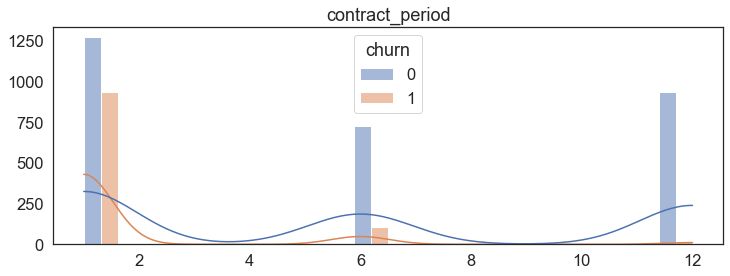

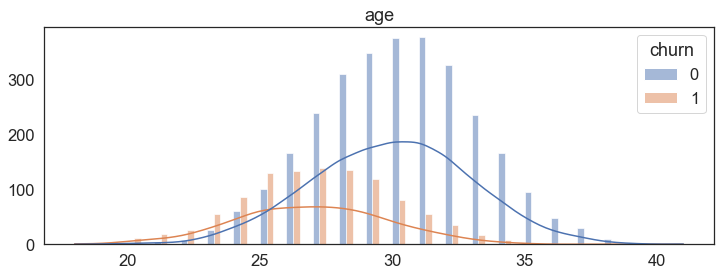

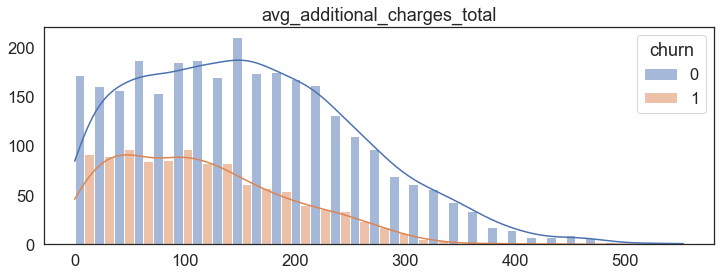

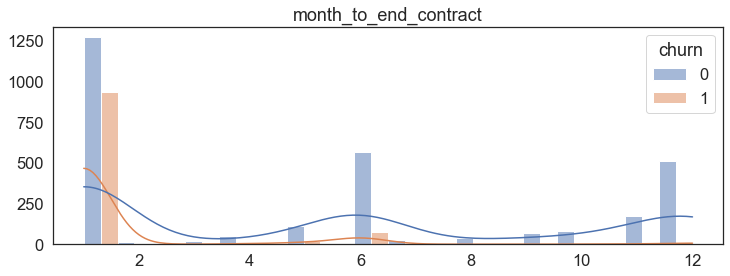

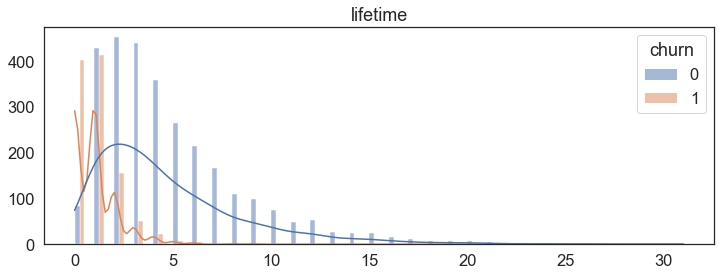

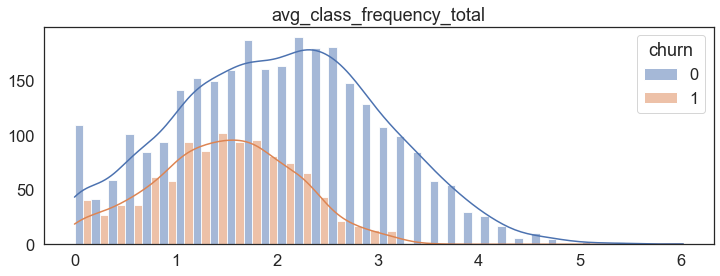

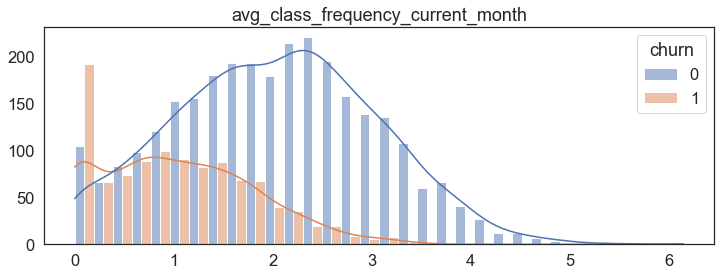

In [7]:
for col in quantitative.drop('churn', axis = 1).columns:
    fig, ax = plt.subplots(figsize=(12, 4))
    sns.histplot(x=quantitative[col], hue=quantitative['churn'], multiple='dodge', bins='auto', kde=True)
    plt.ylabel('')
    plt.xlabel('')
    plt.title(col)
    plt.show();

В целом, распределение похоже на нормальное. Выбросы в виде отсутствия посещений тоже важны для статистики, оставим всё как есть.

Можно заметить, что уходят чаще клиенты с абонементом на один месяц, моложе, которые взяли абонемент недавно, и за последний месяц не посещавшие занятий. Взял абономент на месяц и не ходит, тут и без алгоритмов понятно. Разберемся поподробнее.

### Проверим взаимосвязи между признаками

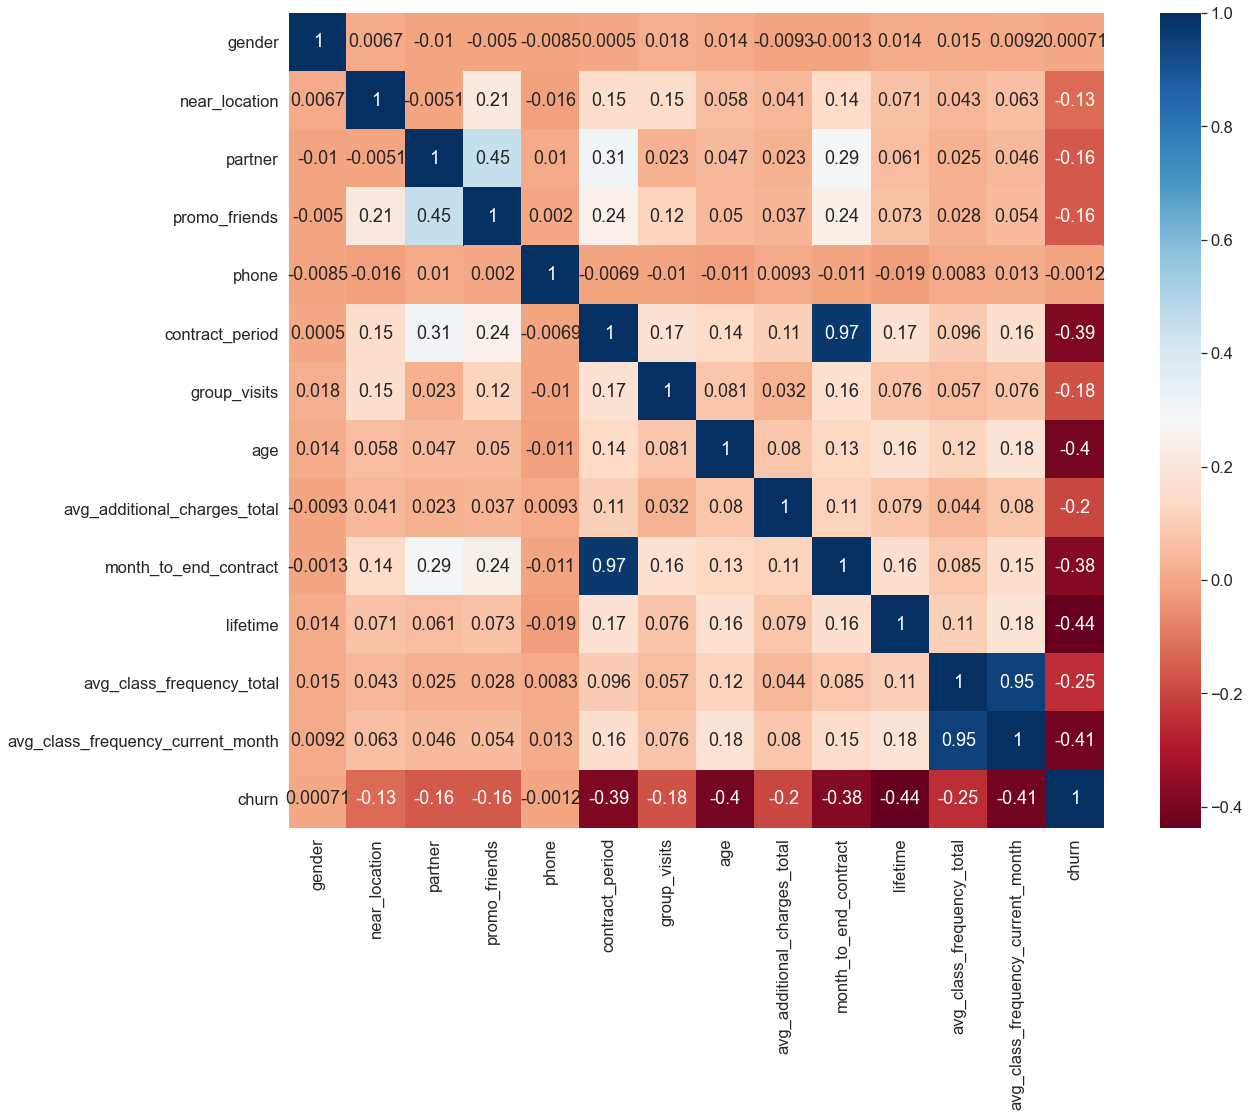

In [8]:
#строим матрицу корреляций
cm = data.corr()

#визуализируем матрицу
fig, ax = plt.subplots(figsize=(20, 15))
sns.heatmap(cm, annot=True, square=True, cmap="RdBu")
plt.show()

Некоторые признаки сильно коррелируют между собой, это может мешать некоторым моделям машинного обучения (линейным моделям), мы получим нерепрезентативные веса и переобученная под эти признаки модель. Проверим корелляцию с целевым признаком и избавимся от того, что меньше влияет. 

'month_to_end_contract' и 'contract_period' - сильная корелляция. У этих признаков умеренная корелляция с целевым, причем, примерно одинаковая. Но оставим мы 'Contract_period' как более удобный для интерпритации и бизнеса.

'avg_class_frequency_total' и 'avg_class_frequency_current_month' - сильная корелляция. Последний сильнее влияет на целевую переменную и может больше рассказать о клиенте, ведь в задаче анализа стоит "за последний месяц".

'partner' и 'promo_friends' - умеренная корелляция. Оба признака слабо кореллируют с целевой переменной. Такая корелляция не должна оказывать сильного влияния на модель. 

Оставим только один из пары, так их влияние на модель будет уменьшено.

Некоторые признаки умеренно кореллируют с целевой переменной: 'contract_period', 'age', 'month_to_end_contract', 'lifetime', 'aVG_class_frequency_current_monyh'. На них стоит обратить внимание, но это не гарантирует зависимость целевого признака от названых. Так же, не стоит отбрасывать признаки с корелляцией близкой к нулю.

Эта таблица показывает только линейную зависимость переменных, но не общее влияние одного на другое. 

## Промежуточный вывод
- Классы не сбалансированы, потому не все признаки хорошо работают. Метрика accuracy_score не будет показательной, лучше смотреть на precision и recall.
- Следует обратить внимание на 'contract_period', 'age', 'month_to_end_contract', 'lifetime', 'aVG_class_frequency_current_monyh', они наиболее сильно влияют на отток клиентов, судя по матрице корелляций и графикам.
- Некоторые переменные очень сильно кореллируют и не внесут ясности в будующий анализ.

# Модель прогнозирования оттока пользователей

Подготовим данные: удалим один из пары коррелирующих признаков, разделим датасет на признаки и целевую переменную, разделим датасет на обучающую и валидационную выборки в соотношении 80/20, стандартизируем данные.

In [9]:
#удаляем сильно коррелирующие признаки
data=data.drop(['month_to_end_contract', 'avg_class_frequency_total'], axis=1)

#разделяем на признаки и целевую переменную
x = data.drop(['churn'], axis=1)
y = data['churn']

#создаем обучающую выборку размером в 80% от оригинальной
x_train, x_rem, y_train, y_rem = train_test_split(x, y, train_size=0.80, random_state=0, stratify=y)
#теперь разделяем оставшуюся часть на валидационную и тестовую. тестовая нужна для финального прогона
x_valid, x_test, y_valid, y_test = train_test_split(x_rem, y_rem, test_size=0.2, random_state=0, stratify=y_rem)

#создадим объект класса StandardScaler и применим его к обучающей выборке
scaler = StandardScaler()
x_train_st = scaler.fit_transform(x_train) #обучаем scaler и одновременно трансформируем матрицу для обучающей выборки

#применяем стандартизацию к матрице признаков для валидационной и тестовой выборки
x_test_st = scaler.transform(x_test)
x_valid_st = scaler.transform(x_valid);

Данные подготовлены, обучим две модели: логистическую регрессию и случайный лес, и посомтри какая лучше на основании метрик.

In [10]:
#создаем функцию для вывода метрик
def print_all_metrics(y_true, y_pred, y_proba, title='Метрики классификации'):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))

#обучаем модель
lr_model = LogisticRegression(random_state=0)

lr_model.fit(x_train_st, y_train)

lr_predictions = lr_model.predict(x_valid_st)
lr_probabilities = lr_model.predict_proba(x_valid_st)[:, 1]

#выводим метрики
print_all_metrics(
    y_valid,
    lr_predictions,
    lr_probabilities,
    title='Метрики для модели логистической регрессии:',
)

Метрики для модели логистической регрессии:
	Accuracy: 0.91
	Precision: 0.84
	Recall: 0.83


Попробуем уменьшить влияние дисбаланса классов.

In [11]:
#обучаем модель с автобалансировщиком классов
lr_model_balanced = LogisticRegression(random_state=0, class_weight='balanced')

lr_model_balanced.fit(x_train_st, y_train)

lr_predictions_balanced = lr_model_balanced.predict(x_valid_st)
lr_probabilities_balanced = lr_model_balanced.predict_proba(x_valid_st)[:, 1]

#выводим метрики
print_all_metrics(
    y_valid,
    lr_predictions_balanced,
    lr_probabilities_balanced,
    title='Метрики для модели логистической регрессии с автобалансом классов:',
)

Метрики для модели логистической регрессии с автобалансом классов:
	Accuracy: 0.90
	Precision: 0.74
	Recall: 0.95


Получился перекос в сторону recall. Попробуем поиграться с параметрами.

In [12]:
#задаем модель
lr = LogisticRegression(random_state = 0, penalty = 'l2')

#задаем диапазоны параметров
max_iter = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
solver = ['lbfgs', 'newton-cg', 'liblinear']
warm_start = [True, False]
C = np.arange(0, 1, 0.01)

param_dist ={
    'max_iter' : max_iter,
    'warm_start' : warm_start,
    'solver' : solver,
    'C' : C,
}

#обучаем модель
rs_lr = RandomizedSearchCV(estimator = lr,
                        param_distributions = param_dist,
                        n_iter = 100,
                        scoring = 'accuracy',
                        n_jobs = -1,
                        verbose = 1, 
                        random_state = 1,
                        )

rs_lr.fit(x_train_st, y_train)
display(rs_lr.best_params_)

#готовим таблицу
rs_lr_df = pd.DataFrame(rs_lr.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
rs_lr_df = rs_lr_df.drop([
            'mean_fit_time', 
            'std_fit_time', 
            'mean_score_time',
            'std_score_time', 
            'params', 
            'split0_test_score', 
            'split1_test_score', 
            'split2_test_score',
            'split3_test_score',
            'split4_test_score',
            'std_test_score'],
            axis=1)
rs_lr_df.head(10)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


{'warm_start': True, 'solver': 'newton-cg', 'max_iter': 300, 'C': 0.09}

,param_warm_start,param_solver,param_max_iter,param_C,mean_test_score,rank_test_score
0,True,newton-cg,300,0.09,0.913125,1
1,True,lbfgs,600,0.14,0.912813,2
2,True,lbfgs,1000,0.03,0.912813,2
3,False,lbfgs,1000,0.14,0.912813,2
4,False,newton-cg,500,0.14,0.912813,2
5,True,lbfgs,500,0.16,0.912812,6
6,True,lbfgs,700,0.17,0.912812,6
7,True,liblinear,700,0.09,0.912500,8
8,False,newton-cg,1000,0.15,0.912500,8
9,False,lbfgs,800,0.15,0.912500,8


С помощью RandomizedSearchCV грубо находим лучшие параметры.

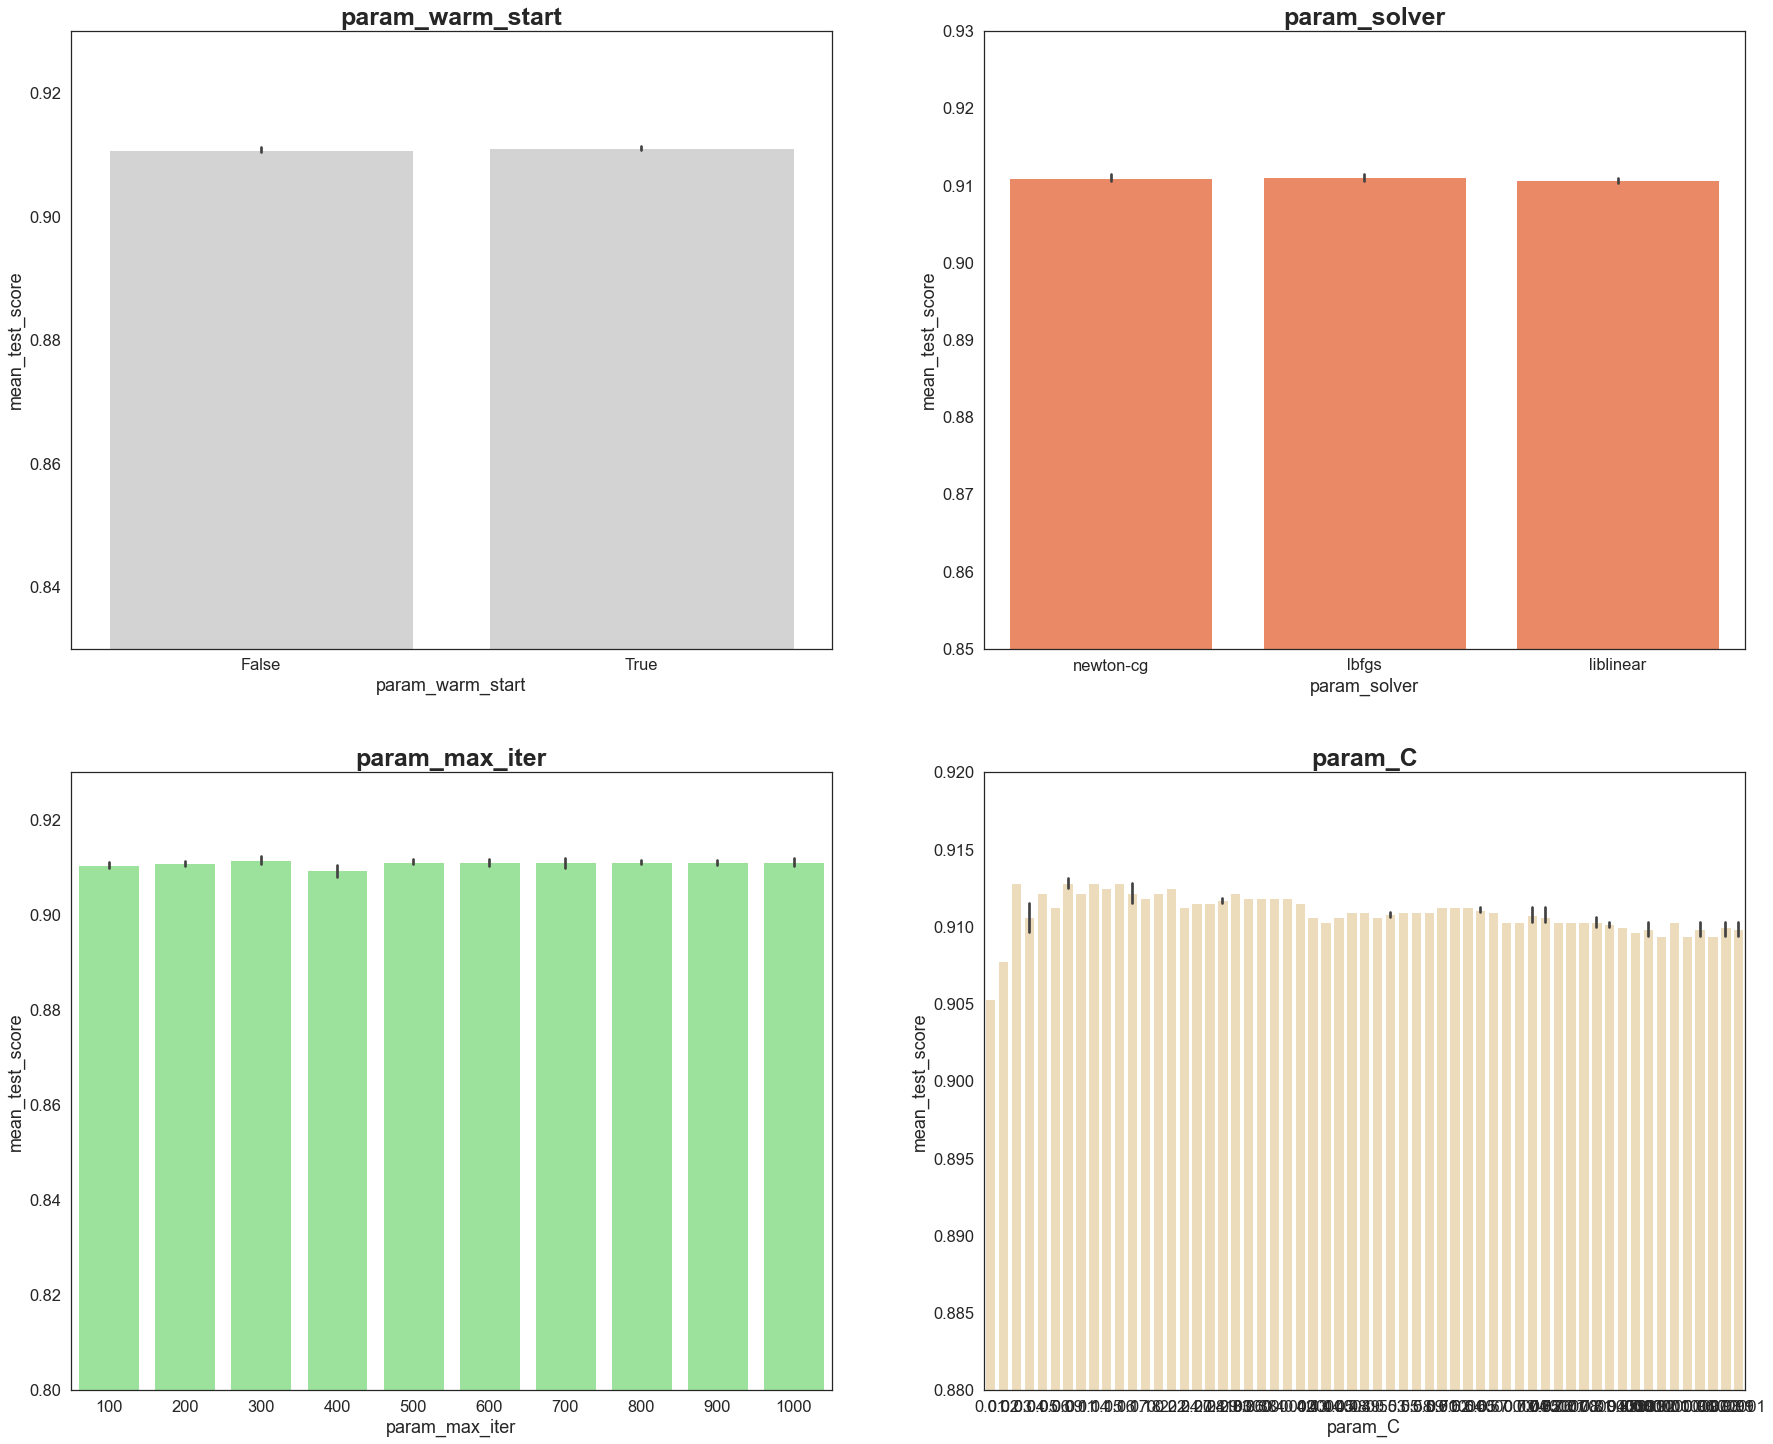

In [13]:
#создаем матрицу графиков, наводим красоту
fig, axs = plt.subplots(ncols=2, nrows=2)
sns.set(style="whitegrid", color_codes=True)
fig.set_size_inches(30,25)

sns.barplot(x='param_warm_start', y='mean_test_score', data=rs_lr_df, ax=axs[0,0], color='lightgrey')
axs[0,0].set_ylim([.83,.93])
axs[0,0].set_title(label = 'param_warm_start', size=25, weight='bold')

sns.barplot(x='param_solver', y='mean_test_score', data=rs_lr_df, ax=axs[0,1], color='coral')
axs[0,1].set_ylim([.85,.93])
axs[0,1].set_title(label = 'param_solver', size=25, weight='bold')

sns.barplot(x='param_max_iter', y='mean_test_score', data=rs_lr_df, ax=axs[1,0], color='lightgreen')
axs[1,0].set_ylim([.80,.93])
axs[1,0].set_title(label = 'param_max_iter', size=25, weight='bold')

sns.barplot(x='param_C', y='mean_test_score', data=rs_lr_df, ax=axs[1,1], color='wheat')
axs[1,1].set_ylim([.88,.92])
axs[1,1].set_title(label = 'param_C', size=25, weight='bold')

plt.show()

Лучших тут, впрочем, много, будем использовать более точный метод GridSearchCV. Передадим ему топовые значения из предыдущего метода.

In [14]:
#получаем лучшие параметры из таблицы
max_iter = rs_lr_df['param_max_iter'].head(5).tolist()
solver = rs_lr_df['param_solver'].value_counts()[:1].index.tolist()
warm_start = rs_lr_df['param_warm_start'].value_counts()[:1].index.tolist()
C = rs_lr_df['param_C'].head(5).tolist()

param_dist ={
    'max_iter' : max_iter,
    'warm_start' : warm_start,
    'solver' : solver,
    'C' : C,
}

#обучаем модель
gs_lr = GridSearchCV(lr, param_dist, cv = 3, verbose = 1, n_jobs=-1)

gs_lr.fit(x_train_st, y_train)
display(gs_lr.best_params_)

Fitting 3 folds for each of 25 candidates, totalling 75 fits


{'C': 0.03, 'max_iter': 300, 'solver': 'lbfgs', 'warm_start': False}

Используем эти параметры для обучения модели.

In [15]:
#обучаем модель с подобранными параметрами
lr_model_gs = LogisticRegression(
    random_state=0,
    warm_start=False,
    solver='lbfgs',
    max_iter=300,
    C=0.03)

lr_model_gs.fit(x_train_st, y_train)

lr_predictions_gs = lr_model_gs.predict(x_valid_st)
lr_probabilities_gs = lr_model_gs.predict_proba(x_valid_st)[:, 1]

#выводим метрики
print_all_metrics(
    y_valid,
    lr_predictions_gs,
    lr_probabilities_gs,
    title='Метрики для модели логистической регрессии с подобранными параметрами:',
)

Метрики для модели логистической регрессии с подобранными параметрами:
	Accuracy: 0.91
	Precision: 0.85
	Recall: 0.81


Получили увеличение метрики precision, отлично. Посмотрим, как справится случайный лес.

In [16]:
#обучаем модель
rf_model = RandomForestClassifier(n_estimators=100, random_state = 0)

rf_model.fit(x_train_st, y_train)

rf_predictions = rf_model.predict(x_valid_st)
rf_probabilities = rf_model.predict_proba(x_valid_st)[:, 1]

#выводим метрики
print_all_metrics(
    y_valid,
    rf_predictions,
    rf_probabilities, 
    title='Метрики для модели случайного леса:'
)

Метрики для модели случайного леса:
	Accuracy: 0.90
	Precision: 0.84
	Recall: 0.78


Попробуем улучшить базовую модель все с тем же RandomizedSearchCV.

In [17]:
#повторяем всё тоже самое с лесом
rfc = RandomForestClassifier()

#готовим параметры
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 1, stop = 15, num = 15)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 30, num = 10)]
min_samples_leaf = [int(x) for x in np.linspace(start = 2, stop = 30, num = 10)]
bootstrap = [True, False]

param_dist = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

#обучаем модель
rs_rfc = RandomizedSearchCV(rfc, 
                        param_dist, 
                        n_iter = 100, 
                        cv = 3, 
                        verbose = 1, 
                        n_jobs=-1, 
                        random_state=0)

rs_rfc.fit(x_train_st, y_train)
display(rs_rfc.best_params_)

#создаем датасет
rs_rfc_df = pd.DataFrame(rs_rfc.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
rs_rfc_df = rs_rfc_df.drop([
            'mean_fit_time', 
            'std_fit_time', 
            'mean_score_time',
            'std_score_time', 
            'params', 
            'split0_test_score', 
            'split1_test_score', 
            'split2_test_score', 
            'std_test_score'],
            axis=1)
rs_rfc_df.head(10)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'n_estimators': 200,
 'min_samples_split': 8,
 'min_samples_leaf': 11,
 'max_features': 'log2',
 'max_depth': 9,
 'bootstrap': True}

,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_bootstrap,mean_test_score,rank_test_score
0,200,8,11,log2,9,True,0.903123,1
1,400,14,8,sqrt,11,True,0.901873,2
2,1000,26,2,sqrt,9,True,0.901873,3
3,700,2,2,log2,11,True,0.901562,4
4,1000,8,5,sqrt,10,True,0.901249,5
5,500,14,14,sqrt,8,False,0.900935,6
6,100,2,11,sqrt,15,False,0.900312,7
7,300,17,5,log2,13,True,0.900311,8
8,300,11,11,sqrt,13,True,0.900311,8
9,400,14,2,sqrt,14,False,0.899999,10


Мы получили грубые параметры, возьмем лучшие из них и еще раз проверим.

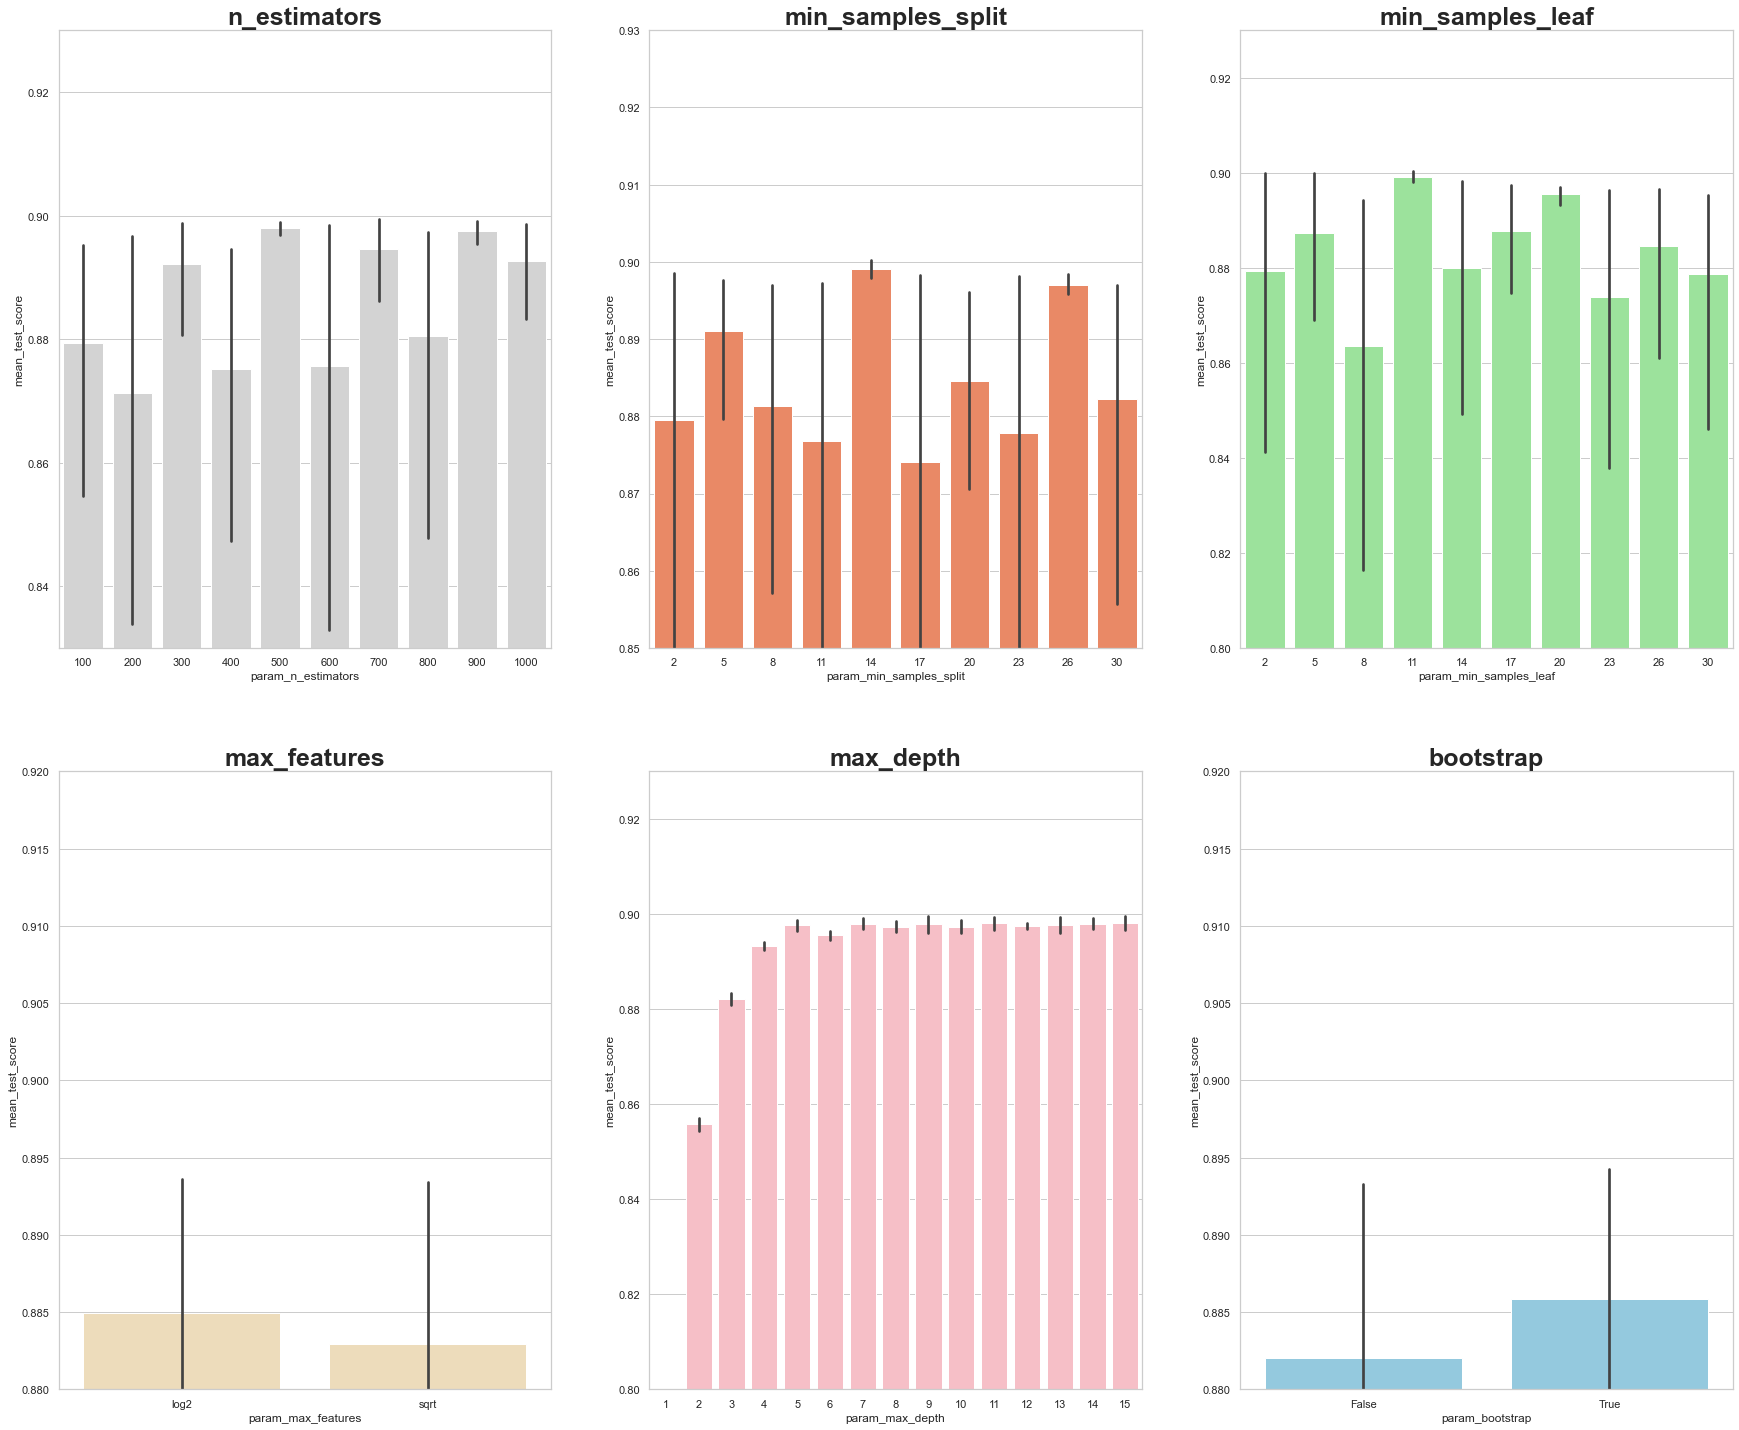

In [18]:
fig, axs = plt.subplots(ncols=3, nrows=2)
sns.set(style="whitegrid", color_codes=True)
fig.set_size_inches(30,25)

sns.barplot(x='param_n_estimators', y='mean_test_score', data=rs_rfc_df, ax=axs[0,0], color='lightgrey')
axs[0,0].set_ylim([.83,.93])
axs[0,0].set_title(label = 'n_estimators', size=25, weight='bold')

sns.barplot(x='param_min_samples_split', y='mean_test_score', data=rs_rfc_df, ax=axs[0,1], color='coral')
axs[0,1].set_ylim([.85,.93])
axs[0,1].set_title(label = 'min_samples_split', size=25, weight='bold')

sns.barplot(x='param_min_samples_leaf', y='mean_test_score', data=rs_rfc_df, ax=axs[0,2], color='lightgreen')
axs[0,2].set_ylim([.80,.93])
axs[0,2].set_title(label = 'min_samples_leaf', size=25, weight='bold')

sns.barplot(x='param_max_features', y='mean_test_score', data=rs_rfc_df, ax=axs[1,0], color='wheat')
axs[1,0].set_ylim([.88,.92])
axs[1,0].set_title(label = 'max_features', size=25, weight='bold')

sns.barplot(x='param_max_depth', y='mean_test_score', data=rs_rfc_df, ax=axs[1,1], color='lightpink')
axs[1,1].set_ylim([.80,.93])
axs[1,1].set_title(label = 'max_depth', size=25, weight='bold')

sns.barplot(x='param_bootstrap',y='mean_test_score', data=rs_rfc_df, ax=axs[1,2], color='skyblue')
axs[1,2].set_ylim([.88,.92])
axs[1,2].set_title(label = 'bootstrap', size=25, weight='bold')
plt.show()

Разбросы большие, есть явные лидеры, с ними и поработаем с помощью GridSearchCV.

In [19]:
#берем лучшие параметры из раздела выше
n_estimators = rs_rfc_df['param_n_estimators'].head(3).tolist()
max_features = rs_rfc_df['param_max_features'].value_counts()[:1].index.tolist()
max_depth = rs_rfc_df['param_max_depth'].head(3).tolist()
min_samples_split = rs_rfc_df['param_min_samples_split'].head(3).tolist()
min_samples_leaf = rs_rfc_df['param_min_samples_leaf'].head(3).tolist()
bootstrap = rs_rfc_df['param_bootstrap'].value_counts()[:1].index.tolist()

param_dist = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

#обучаем
gs_df = GridSearchCV(rfc, param_dist, cv = 3, verbose = 1, n_jobs=-1)
gs_df.fit(x_train_st, y_train)

display(gs_df.best_params_)

Fitting 3 folds for each of 81 candidates, totalling 243 fits


{'bootstrap': False,
 'max_depth': 11,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 8,
 'n_estimators': 200}

Лучшие из лучших, посмотрим, как с такими параметрами поведет себя модель.

In [20]:
#обучаем модель с параметрами
rf_model_gs = RandomForestClassifier(n_estimators=100, random_state = 0)

rf_model_gs.fit(x_train_st, y_train)

rf_predictions_gs = rf_model_gs.predict(x_valid_st)
rf_probabilities_gs = rf_model_gs.predict_proba(x_valid_st)[:, 1]

#выводим метрики
print_all_metrics(
    y_valid,
    rf_predictions_gs,
    rf_probabilities_gs, 
    title='Метрики для модели случайного леса с параметрами:'
)

Метрики для модели случайного леса с параметрами:
	Accuracy: 0.90
	Precision: 0.84
	Recall: 0.78


Не впечатляет. Время сравнить все результаты.

In [21]:
#выводим метрики
print_all_metrics(
    y_valid,
    lr_predictions,
    lr_probabilities,
    title='Метрики для модели логистической регрессии:',
)

print_all_metrics(
    y_valid,
    lr_predictions_balanced,
    lr_probabilities_balanced,
    title='Метрики для модели логистической регрессии с автобалансом классов:',
)

print_all_metrics(
    y_valid,
    lr_predictions_gs,
    lr_probabilities_gs,
    title='Метрики для модели логистической регрессии с подобранными параметрами:',
)

print_all_metrics(
    y_valid,
    rf_predictions,
    rf_probabilities, 
    title='Метрики для модели случайного леса:'
)

print_all_metrics(
    y_valid,
    rf_predictions_gs,
    rf_probabilities_gs, 
    title='Метрики для модели случайного леса с подобранными параметрами:'
)

Метрики для модели логистической регрессии:
	Accuracy: 0.91
	Precision: 0.84
	Recall: 0.83
Метрики для модели логистической регрессии с автобалансом классов:
	Accuracy: 0.90
	Precision: 0.74
	Recall: 0.95
Метрики для модели логистической регрессии с подобранными параметрами:
	Accuracy: 0.91
	Precision: 0.85
	Recall: 0.81
Метрики для модели случайного леса:
	Accuracy: 0.90
	Precision: 0.84
	Recall: 0.78
Метрики для модели случайного леса с подобранными параметрами:
	Accuracy: 0.90
	Precision: 0.84
	Recall: 0.78


Похоже, логистическая регрессия с настроенными параметрами показывает лучший prcision. Обучим эту модель на тестовой выборке.

In [22]:
#используем тестовую выборку, которую модель еще не встречала
lr_predictions_gs = lr_model_gs.predict(x_test_st)
lr_probabilities_gs = lr_model_gs.predict_proba(x_test_st)[:, 1]

#выводим метрики
print_all_metrics(
    y_test,
    lr_predictions_gs,
    lr_probabilities_gs,
    title='Метрики для модели логистической регрессии с подобранными параметрами:',
)

Метрики для модели логистической регрессии с подобранными параметрами:
	Accuracy: 0.92
	Precision: 0.87
	Recall: 0.81


Модель показывает хороший результат на незнакомой выборке.

In [23]:
#оцениваем важность каждого признака
lr_data = pd.DataFrame(data={'name': x_train.columns,'lr_importances': abs(lr_model_gs.coef_[0])})
display(lr_data.sort_values(by='lr_importances', ascending=False));

,name,lr_importances
9,lifetime,1.908657
5,contract_period,1.000779
10,avg_class_frequency_current_month,0.957533
7,age,0.888914
8,avg_additional_charges_total,0.428394
6,group_visits,0.281383
3,promo_friends,0.127242
2,partner,0.096242
1,near_location,0.069009
4,phone,0.044702


Логистическая регрессия с настроенными параметрами показала себя лучше других моделей. Наиболее важная метрика, представленная обеими моделями- 'Lifetime'.

# Кластеризация пользователей

Разобьем клиентов на группы. Для этого уберем целевой признак и по методу linkage построим дендограмму, на ней будет хорошо видно группы.

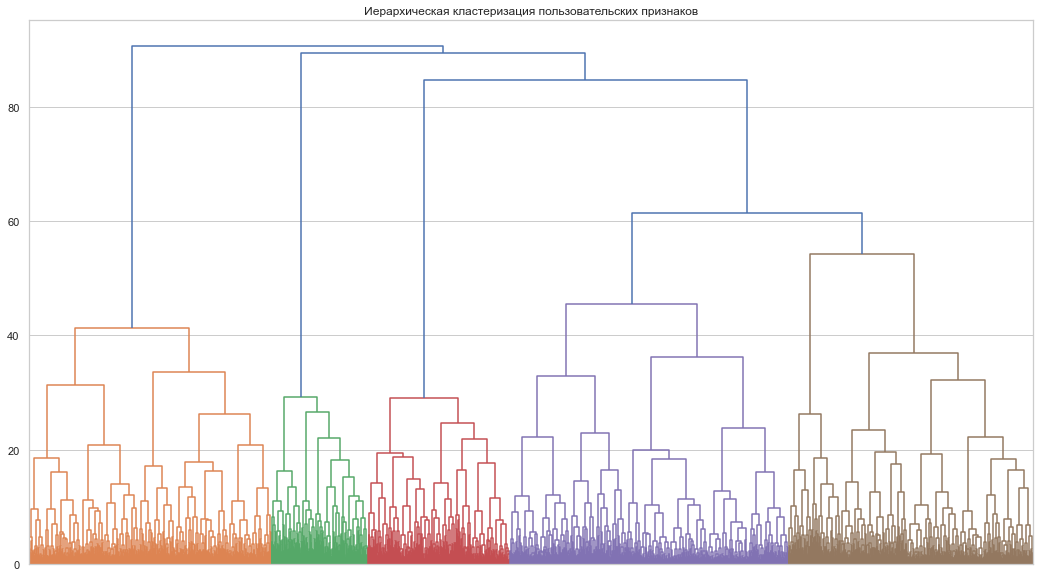

In [24]:
#убираем целевой признак
data_new = data.drop(['churn'], axis=1)

#создаем иерархическую кластеризацию
data_st = scaler.fit_transform(data_new)
linked = linkage(data_st, method = 'ward')

#визуализируем ее
plt.figure(figsize=(18, 10)) 
dendrogram(linked, orientation='top', no_labels=True, color_threshold=60)
plt.title('Иерархическая кластеризация пользовательских признаков')
plt.show();

На графике хорошо прослеживаются 5 групп, они окрашены в разные цвета. Разбиение зависит от задач, для нашей задачи хватит и 5 групп. Разделим клиентов на 5 кластеров и посчитаем среднее по каждому признаку на основании алгоритма K-Means:

In [25]:
#делим выборку на кластеры
km = KMeans(n_clusters=5, random_state=0)
clusters = km.fit_predict(data_st)
data['cluster'] = clusters

#размер каждого кластера
cluster_count = (
    data
    .pivot_table(
        index='cluster',
        values='contract_period',
        aggfunc='count')
    .reset_index()
    .rename(columns={'contract_period':'cluster_size'})
)

#таблица с переменными кластеров
cluster_features = (
    data
    .groupby(['cluster'])
    .mean()
    .reset_index()
    .T
    .style
    .background_gradient(cmap='coolwarm', axis=1)
    .set_precision(2)
)

display(cluster_count)
display(cluster_features)

,cluster,cluster_size
0,0,985
1,1,558
2,2,1064
3,3,1007
4,4,386


,0,1,2,3,4
cluster,0.00,1.00,2.00,3.00,4.00
gender,0.50,0.50,0.50,0.53,0.52
near_location,1.00,0.00,1.00,1.00,0.86
partner,0.89,0.49,0.22,0.38,0.47
promo_friends,1.00,0.08,0.07,0.01,0.31
phone,1.00,1.00,1.00,1.00,0.00
contract_period,6.92,2.99,2.01,6.21,4.78
group_visits,0.52,0.23,0.28,0.54,0.43
age,29.61,28.68,27.58,30.70,29.30
avg_additional_charges_total,153.42,137.13,119.34,176.26,144.21


Средние значения по кластерам:

'gender' — пол, примерно поровну.

'near_Location' — кластер 0 не включает в себя местных жителей или работающий рядом.

'partner' — в кластер 1 входят клиенты, почти полностью пришедшие по партнерской программе.

'promo_friends' — так же в кластер 1 входят клиенты по приглашению друзей.

'phone' — кластер 4 без оставленных номеров телефона.

'contract_period' — в кластере 1 самый большой оставшийся срок действия абонемента - 7 месяцев против 3-4 в других.

'group_visits' — кластер 2 для клиентов без групповых занятий, кластер 3 только для клиентов с групповыми занятиями.

'age' — возраст не повлиял на разделение по группам.

'avg_additional_charges_total' — средняя выручка от других услуг везде похожа.

'lifetime' — везде около 3-4 месяцев.

'avg_class_frequency_total' — во всех кластерах примерно одинаковое количество посещений в неделю - 2.

'churn' — в кластере 0 и 2 около 40% клиентов ушли, в остальных 12-26%.

### Построим графики распределения признаков по кластерам

In [26]:
#разделим таблицу на категориальные и количественные признаки
categorical_names = data.columns[data.max() == 1].tolist()
quantitative_names = data.columns[data.max() > 1].tolist()

categorical_cluster = data[categorical_names]
categorical_cluster = categorical_cluster.assign(cluster=data['cluster'])
quantitative_cluster = data[quantitative_names]
quantitative_cluster = quantitative_cluster.assign(churn=data['churn'])

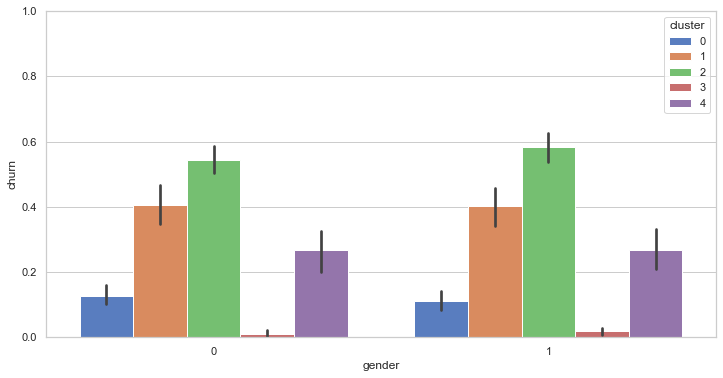

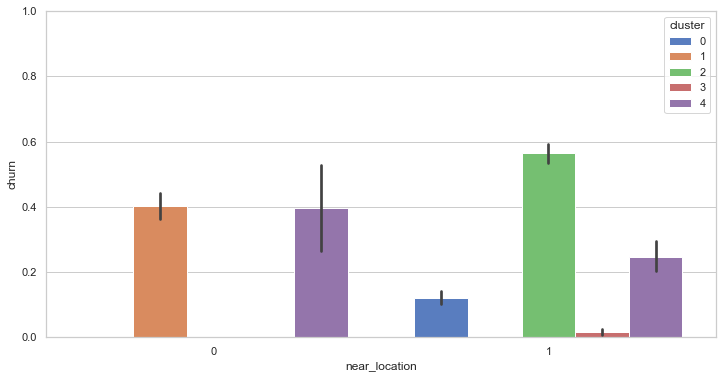

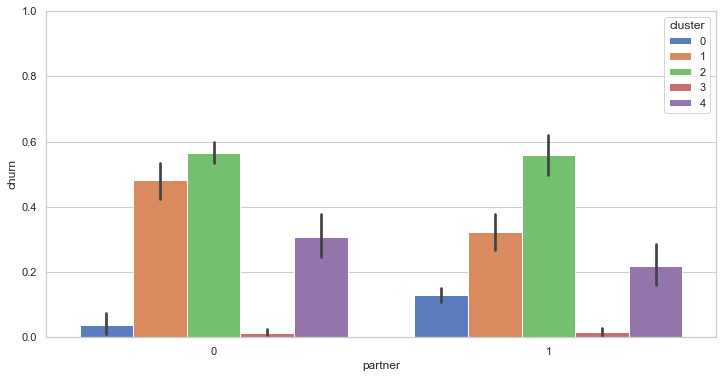

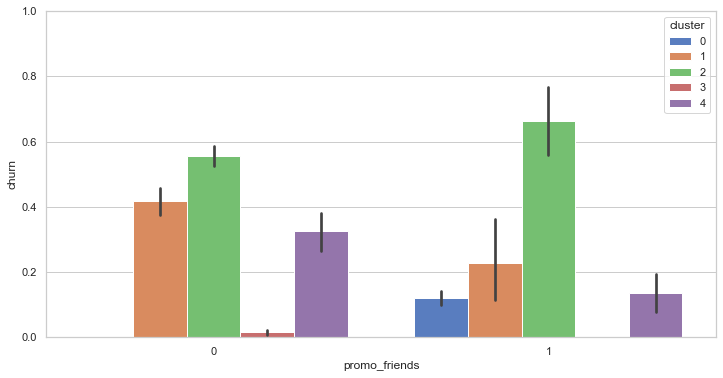

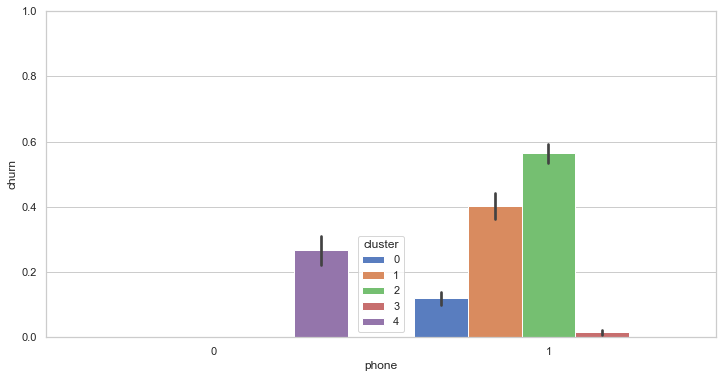

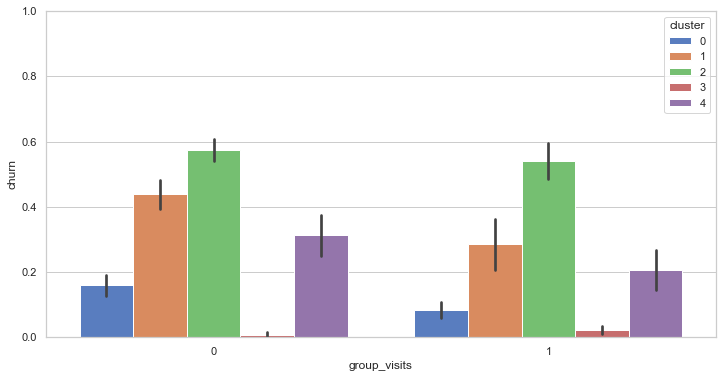

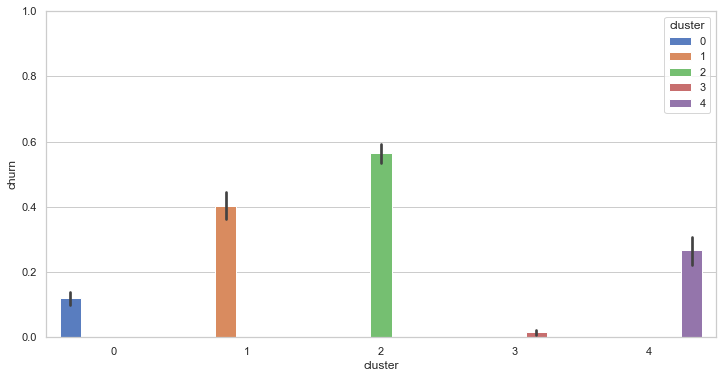

In [27]:
#рисуем графики для категоральных переменных
for col in categorical_cluster.drop('churn', axis = 1).columns:
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.barplot(
        x=categorical_cluster[col],
        y=categorical_cluster['churn'],
        hue=categorical_cluster['cluster'],
        palette='muted'
    )
    plt.ylim(0, 1)
    plt.show();

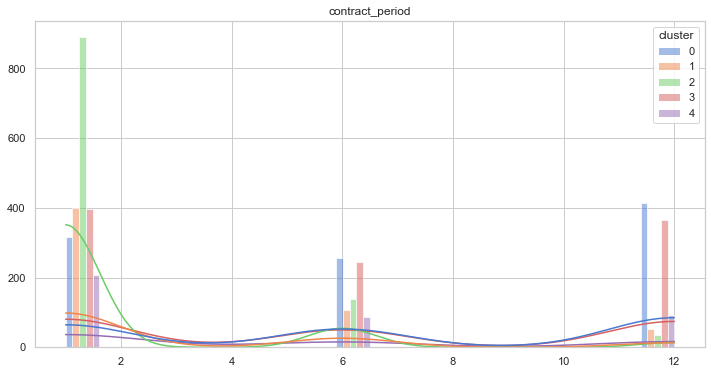

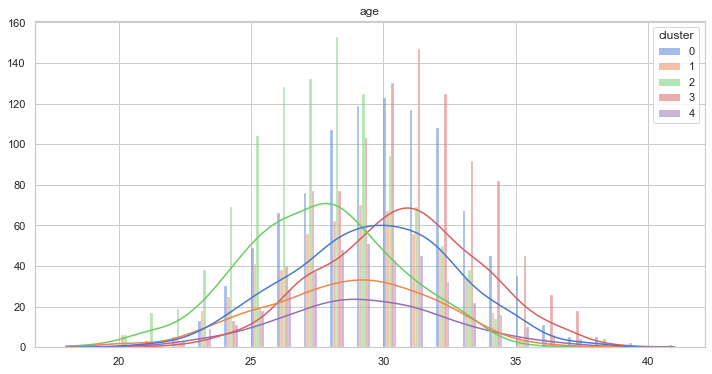

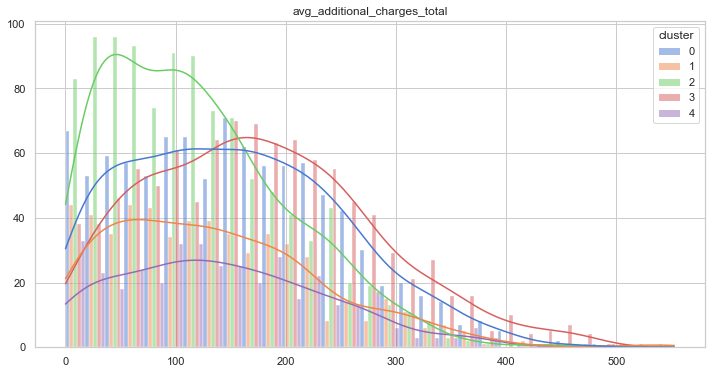

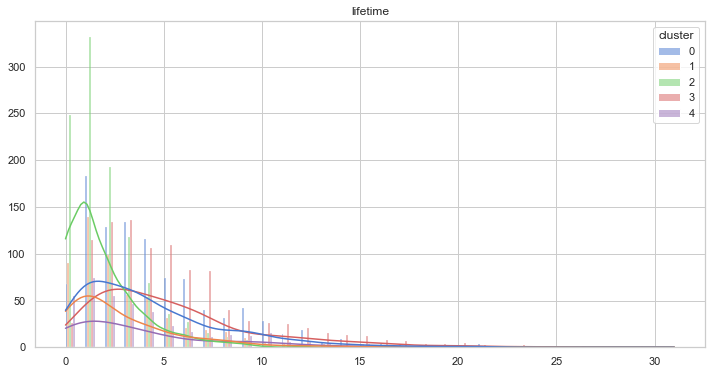

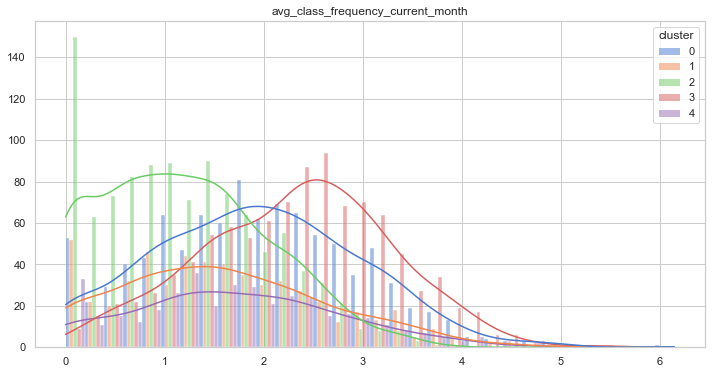

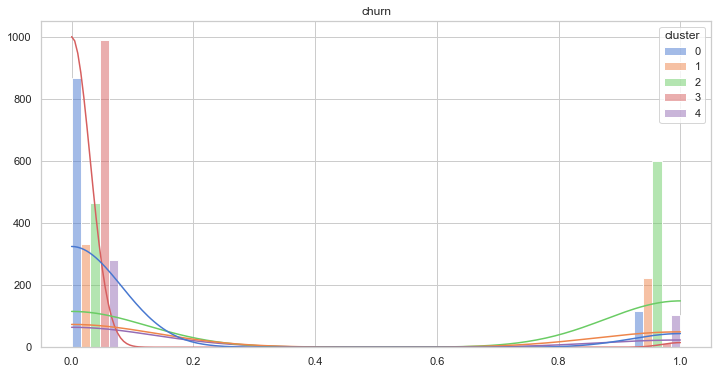

In [28]:
#рисуем графики для количественных переменных 
for col in quantitative_cluster.drop('cluster', axis = 1).columns:
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.histplot(
        x=quantitative_cluster[col], 
        hue=quantitative_cluster['cluster'],
        multiple='dodge', bins='auto',
        kde=True,
        palette='muted'
    )
    plt.ylabel('')
    plt.xlabel('')
    plt.title(col)
    plt.show();

C:\Users\moroz\AppData\Local\Temp\ipykernel_4824\2290981541.py:21: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


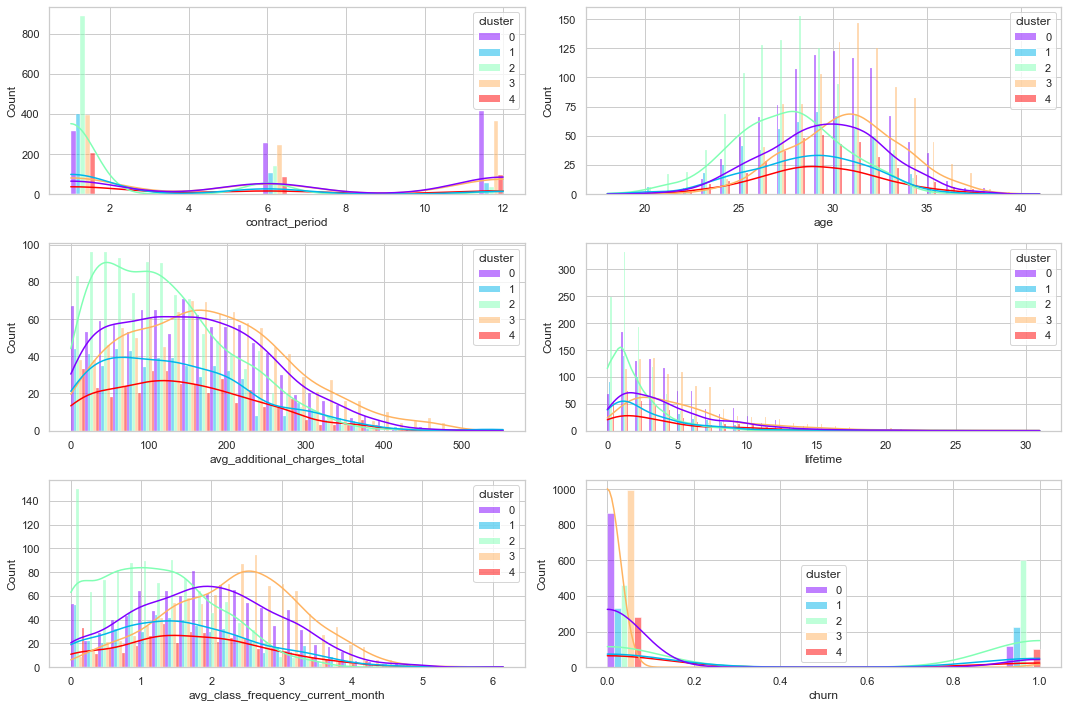

In [29]:
fig, ax = plt.subplots(nrows = 3, ncols=2, figsize=(15, 10))
ax = ax.flatten()

#рисуем графики для количественных переменных 
for i, col in enumerate(quantitative_cluster.drop('cluster', axis = 1).columns):

    sns.histplot(
        x=quantitative_cluster[col], 
        hue=quantitative_cluster['cluster'],
        multiple='dodge', bins='auto',
        kde=True,
        palette='rainbow', ax = ax[i]
    )
#     plt.ylabel('')
#     plt.xlabel('')
#     plt.title(col)
#     plt.show();

# чтобы все надписи влезли    
fig.tight_layout()
fig.show()


Графики согласуются с описанием таблицы. На них можно более наглядно оценить кластеры пользователей.

В кластерах 1 и 2 наибольшее количество пользователей. Меньше всего в 4.

Посчитаем долю оттока для каждого кластера:

In [30]:
df= data[['cluster', 'churn']].groupby(['cluster']).mean().reset_index()
df['churn'] = round(df['churn']*100, 1)
df = df.rename(columns={'churn':'Средний отток, %'}).sort_values(by='Средний отток, %', ascending=False)
display(df)

,cluster,"Средний отток, %"
2,2,56.4
1,1,40.3
4,4,26.7
0,0,12.0
3,3,1.5


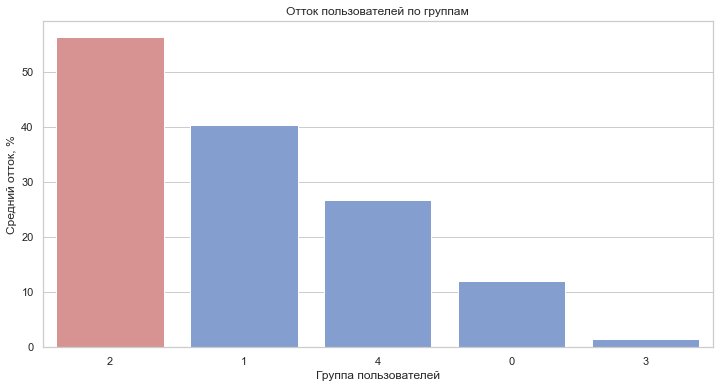

In [31]:
fig, ax = plt.subplots(figsize=(12, 6))
values = df['Средний отток, %']
clrs = ['#769adc' if (x<max(values)) else '#e18886' for x in values]

sns.barplot(
    x='cluster',
    y='Средний отток, %',
    data = df,
    order=df['cluster'],
    palette=clrs
           )
plt.title('Отток пользователей по группам')
plt.xlabel(u'Группа пользователей')
plt.show();

Наибольший отток клиентов в кластере 0, сразу за ним 2, наимениьший отток в кластере 1.

### Описание кластеров
0 - четвертый по численности, клиенты не работают и не живут поблизости, пришли скореев сего по приглашению друзей, оставивляют номер телефона, заключают контракт на месяц. На групповые занятия не ходят. В 40% случаев перестают ходить в зал.

1 - вторая по численности группа, живут или работают рядом, пришли по партнерской программе или (и) по приглашению друзей. Оставляют свой номер телефона и чаще всего берут абонемент на год. Самый низкий процент оттока - 12%.

2 - самая многочисленная группа, живут или работают рядом. Оставляют номер телефона, заключают контракт на месяц в большинстве случаев и не посещают групповые занятия. Большой процент оттоа - 38%.

3 - третий по численности, живут или работают рядом, редко являются участниками-партнерами, редко по приглашению друзей. Всегда оставляют номер телефона и всегда ходят на групповые занятия. Отток около 20%.

4 - наименее многочисленный. Живут рядом и не оставляют номер телефона, чаще всего берут абонемент на месяц. Отток 27%.

# Выводы

Все данные представлены в удобном формате, приведены к единому стилю и не содержат пропусков или сильно выбивающихся значений. Предварительный анализ показал, что не местные клиенты с абонементом на месяц, которые пришли недавно по партнерской программе или по приглашению чаще перестают ходить в зал. А местные, которые активно ходят в зал и на групповые занятия с абонементом на год самые надежные клиенты.

Проведенный анализ данных на обучающей и валидационной выборке показал, что модель логистической регрессии с подобранными параметрами может предсказать отток клиентов в будущем с долей правильных 92%, но лучше смотреть на совокупность метрик точности и полноты, которые обратно зависимы и составляют 87% и 81% соответственно.

При условии, что стоимость удержания клиента невысока, ключевой становится метрика точности (precision), так как позволяет выявить больше потенциально уходящих клиентов.

Согласно модели, ключевыми признаками по оотоку клиентов являются: lifetime (время с первого обращения в центр), contract_period (срок действия абонемента), avg_class_frequency_current_month (среднее количество посешений ща последний месяц), age (возраст).

Клиентов можно условно разделить на 5 групп различного состава. Размер групп разнится от 1000 до 400 человек, что составляет от 10% до 25% от общего числа ввыборке. 

Наиболее вероятно уйдет клиент с большим временем обращения в фитнес-центр. Но так же следует выделить несколько заметных групп клиентов:

- Не местные клиенты, пришедшие "попробовать" на месяц по приглашению. Почти половина таких перестает ходить в зал в будущем.
- Местные (или работающие рядом) клиенты, которые берут абонемент на год. Чуть больше 10% перестают пользоваться услугами центра.
- Такие же клиенты, но взявшие абонемент на месяц и не ходившие на групповые занятия, втрое чаще бросают тренировки. Самый частый тип клиента.
- Местные, которые ходят на групповые занятия. Прекращает ходить в зал 1 из 5.
- Местные клиенты, не оставляющие свой номер телефона, но посещающие групповые тренировки. Не ходит в зал в последствии 1 из 4.

# Рекомендации

Наиболее перспективный способ удержания клиентов, исходя из модели, предлагать более выгодные условия для долгосрочных контрактов и активная работа сразу после первого обращения. Чем больше времени прошло с первого обращения, тем выше шанс, что клиент "отвалится". Нужно уделять больше внимания местным клиентам, которые гораздо реже бросают тренировки, особенно, если оставляют свой номер телефона и ходят на групповые занятия.